In [93]:
import numpy as np
import matplotlib.pyplot as plt
import helpers as hp
import simulate as si
import toy_problem_analytical as tpa

# Toy Problem
Constant heat at the bottom and the top is room temperature.

In [94]:
# Define parameters
b0 = 150 # u(0,t)= b0 (boundary cond)
bL = 20 # u(L,t)= bL (boundary cond)
D = 0.143*10**(-4) # thermal diffusivity coefficient - in the liquid
a = 0 # heat transfer coefficient of liquid through container to air - for sink term along sides of can
T = 300 # final time 
L = 0.13 # Length (i.e. height) of the can
Nt_points = 2000    # number of timesteps
Nx_points = 100   # number of spaces in x

u_inf = bL # air temperature - for this problem we say that the temperature at end of rod is fixed at air temp

# Set initial condition
u0 = np.zeros(Nx_points)
u0[0] = b0
u0[1:] = bL*np.ones(Nx_points-1)

# Set up time related functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

# run simulation
U = si.simulate_dirichlet_sink(u0, lambda t: b0, D, T, Nt_points, L, Nx_points, 0)

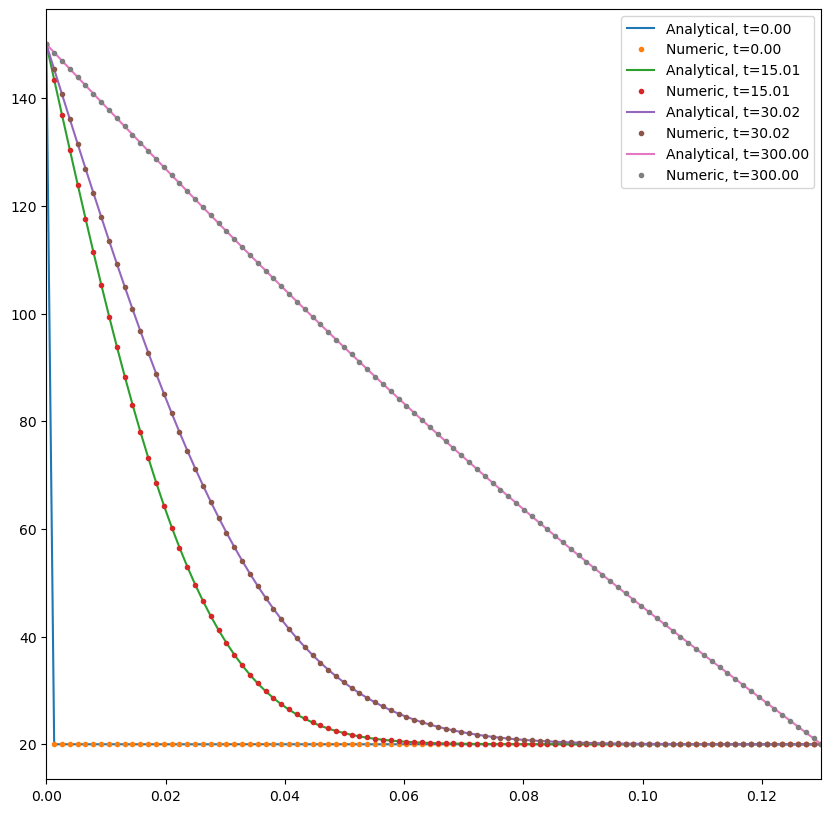

In [95]:
# Compare to analytic solution

U_analyt = tpa.create_analytic_toy_fn(b0, bL, L, D)
x = np.linspace(0,L,Nx_points)

fig, ax = plt.subplots(figsize = (10,10))

for i in (0, Nt_points//20, Nt_points//10, Nt_points - 1):
    t = index_to_time(i)
    ax.plot(x, U_analyt(x, t), "-", label = f"Analytical, {t=:.2f}")
    ax.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
    
plt.xlim(0,L)
plt.legend()
plt.show()

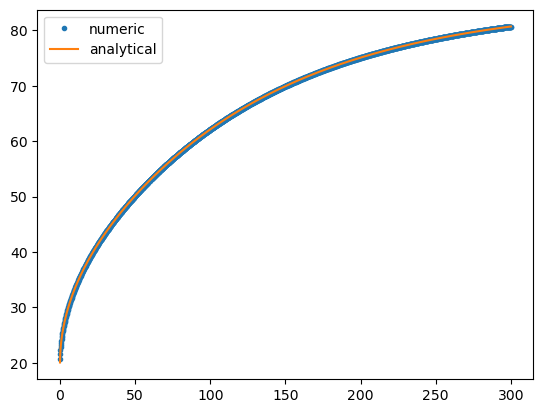

In [96]:
avg_temp_analytic = tpa.create_analytic_avg_temp(b0, bL, L, D)
avg_temp_numeric = si.create_numeric_avtemp_fn(U, 1/(Nx_points - 1), time_to_index)

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.plot(t, avg_temp_analytic(t), "-", label = "analytical")
plt.legend()
plt.show()

In [97]:
num_tto80 = si.time_to_temp(avg_temp_numeric(t), 80, index_to_time)
analyt_tto80 = si.time_to_temp(avg_temp_analytic(t), 80, index_to_time)

print(f"{num_tto80=}, {analyt_tto80}")

# Find maximum average temperature

k = np.linspace(0, T, Nt_points)
averages = avg_temp_numeric(k)

print('Maximum average temperature is :',averages.max())

num_tto80=282.2911455727864, 281.9909954977489
Maximum average temperature is : 80.69137540328468


# Observations
- The numerical solution of the diffusion equation and the integral and accurate compared to the analytic solution
- When the bottom of the can is 150 and the top is 20 the liquid takes 4.7 minutes to reach an average temperature of 80 degrees
- Maximum average temperature is 80.7 degrees

# Realistic Model
Examine what happens when there is a sink term and a Newton cooling top boundary condition and it takes time for the bottom of the can to heat up

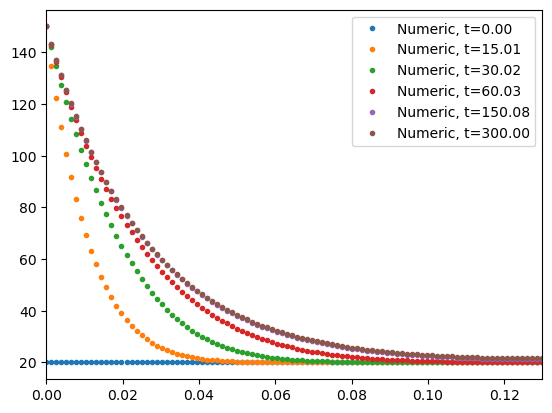

In [98]:
# Define the function that causes the heating element to take time to warm up
def b0(t):
    if t <= 15:
        return (150 - 20)*(t/15) + 20
    else:
        return 150

# Define parameters
bL = 20 # u(L,t)= bL (boundary cond)
D = 0.143*10**(-4) # thermal diffusivity coefficient - in the liquid
T = 300 # final time 
L = 0.13 # Length (i.e. height) of the can
Nt_points = 2000    # number of timesteps
Nx_points = 100   # number of spaces in x
u_inf = bL # air temperature - for this problem we say that the temperature at end of rod is fixed at air temp

W = 0.0005 # Thickness of the top of the can
r1 = 0.04 # Radius of the liquid in the can (up to the interior surface of the can)
r2 = 0.0405 # Radius of the liquid in the can (up to the exterior of the can)
kS = 16 # Thermal conductivity of stainless steel
hA = 750 # Heat transfer coefficient of water
hB = 10 # Heat transfer coefficient of air
kW = 0.6 # Thermal conductivity of water

a = hp.sink_HTC(L, r1, r2, kS, hA, hB) # heat transfer coefficient of liquid through container to air - for sink term along sides of can
h = hp.boundary_condition_HTC(W, r1, kS, hA, hB) # heat transfer coefficient of liquid through container to air - top of can

# Set initial condition
u0 = np.zeros(Nx_points)
u0[0] = b0(0)
u0[1:] = u_inf*np.ones(Nx_points-1)

# Simulate the solution
U = si.simulate_sink_with_fancy_bcs(u0, b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf, 2*r1)

# Redo time functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

for i in (0, Nt_points//20, Nt_points//10, Nt_points//5, Nt_points//2, Nt_points - 1):
    t = index_to_time(i)
    plt.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
plt.xlim(0,L)   
plt.legend()
plt.show()

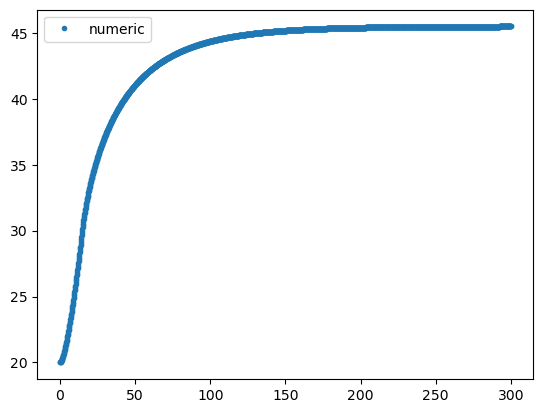

In [99]:
# Check average temperature
avg_temp_numeric = si.create_numeric_avtemp_fn(U, 1/(Nx_points - 1), time_to_index)

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.legend()
plt.show()

In [100]:
num_tto45 = si.time_to_temp(avg_temp_numeric(t), 45, index_to_time)

print(f"{num_tto45=}")

# Find maximum average temperature
k = np.linspace(0, T, Nt_points)
averages = avg_temp_numeric(k)

print('Maximum average temperature is :',averages.max())

num_tto45=132.66633316658329
Maximum average temperature is : 45.482833310082235


# Observations
- Taking into consideration heat loss out the top and sides and a heating element that takes time to heat up produces results worse than the toy model
- The heat loss out of the can is so much that the top of that barely heats up, this causes the can to reach an average temperature of 45 degrees in 2.2 minutes but have a maximum average temperature of 45.5 degrees.
- Note that since the top barely increases from 20 degrees this implies that the heat loss out of the sides of the can has a large impact on the temperature of the liquid within the can
- If a can functions like this model the temperature in the can will not reach the desirable temperature of 80 degrees in a realistic amount of time

# More insulated but not completely
This model has a heating element that takes time to warm up and looses heat out of the top but not out of the sides

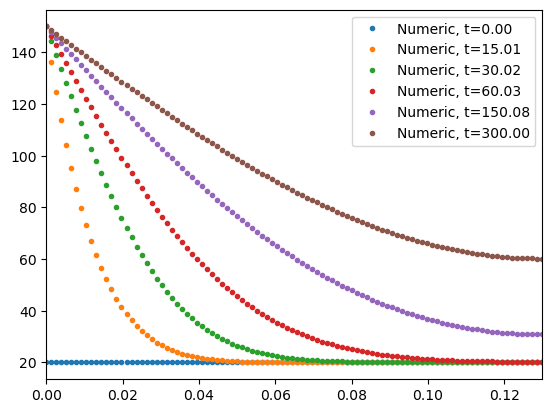

In [101]:
a = 0 # Turn off the sink term

# Simulate the solution
U = si.simulate_sink_with_fancy_bcs(u0, b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf)

# Redo time functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

for i in (0, Nt_points//20, Nt_points//10, Nt_points//5, Nt_points//2, Nt_points - 1):
    t = index_to_time(i)
    plt.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
plt.xlim(0,L)   
plt.legend()
plt.show()

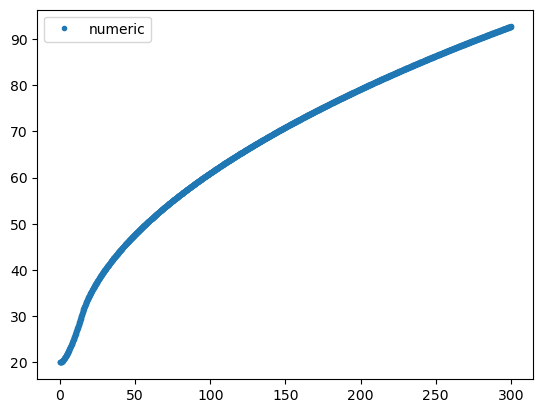

In [102]:
avg_temp_numeric = si.create_numeric_avtemp_fn(U, 1/(Nx_points - 1), time_to_index)

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.legend()
plt.show()

In [103]:
num_tto80 = si.time_to_temp(avg_temp_numeric(t), 80, index_to_time)

print(f"{num_tto80=}")

# Find maximum average temperature
k = np.linspace(0, T, Nt_points)
averages = avg_temp_numeric(k)

print('Maximum average temperature is :',averages.max())

num_tto80=205.60280140070034
Maximum average temperature is : 92.68224364208848


# Observations
- When the sides of the can are insulated the can performs much better, even thought the top is still loosing heat and the heating element takes time to warm up.
- In this case it takes just under 3.42 minutes to reach an average temperature of 80 degrees. This is better than the toy model even though the heating element takes time to heat up.
- The maximum average temperature is 92.68 degrees

# Insulated Model
No sink term and a Neuman boundary condition at the top so that no heat is lost out of the top or sides. The heating element still takes time to heat up.

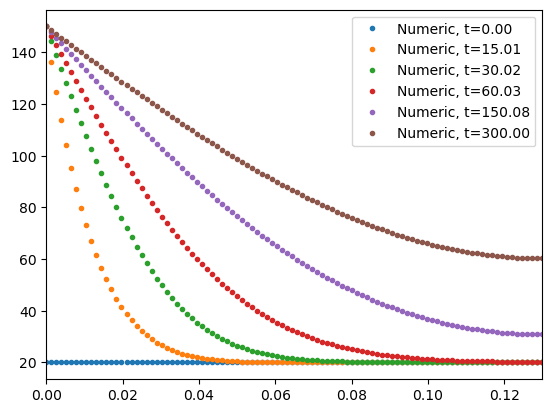

In [104]:
#b0 = 500 # Uncomment this and the one below to test constant boundary conditions

# Simulate the solution
#U = si.simulate_sink_with_fancy_bcs(u0, lambda t: b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf, True)
U = si.simulate_sink_with_fancy_bcs(u0, b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf, insulated = True)

# Redo time functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

for i in (0, Nt_points//20, Nt_points//10, Nt_points//5, Nt_points//2, Nt_points - 1):
    t = index_to_time(i)
    plt.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
plt.xlim(0,L)   
plt.legend()
plt.show()

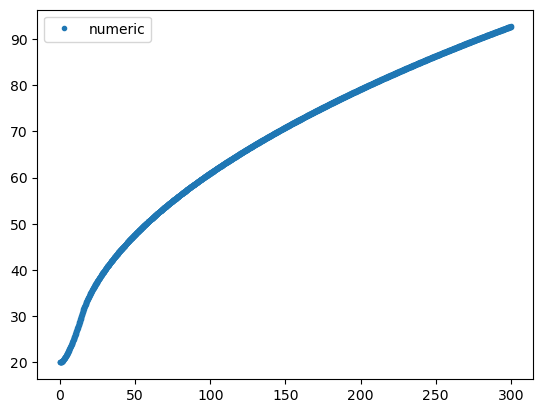

In [105]:
avg_temp_numeric = si.create_numeric_avtemp_fn(U, 1/(Nx_points - 1), time_to_index)

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.legend()
plt.show()

In [106]:
num_tto80 = si.time_to_temp(avg_temp_numeric(t), 80, index_to_time)

print(f"{num_tto80=}")

# Find maximum average temperature
k = np.linspace(0, T, Nt_points)
averages = avg_temp_numeric(k)

print('Maximum average temperature is :',averages.max())

num_tto80=205.60280140070034
Maximum average temperature is : 92.71972178448564


# Observations
- This model looks almost identically to the one with the Newton cooling boundary condition
- It takes 3.42 minutes to reach an average temperature of 80 degrees. The maximum average temperature is 92.72 which is 0.04 degrees greater than the model that has heat loss out of the top of the can
- This implies that insulating the whole can may not be worth the addition costs that may arise in manufactoring or a decrease in functionality.
- It is clearly worth insulating the sides because the can did not even heat up to the desired temperature previously but the difference in the performance when it is fully insulated versus just the top is very small, thus it is unlikely that the good outways the cost.